In [1]:
from datasets import load_dataset
import pandas as pd
import logging
import time
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_groq import ChatGroq
import os
from langchain_cohere import ChatCohere

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import display, HTML
import json

d:\Teias\Thesis\self-explaination-thesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cohere
import os

# Initialize the Cohere client with your API key
co = cohere.ClientV2(api_key=os.getenv("COHERE_API_KEY", "k4nv2XHVUMI9IDp3R4TV5jyzax5DufqG1nZDh5up"))

In [38]:
# Define the Q&A task
context = "The capital of France is Paris, known for its art and culture."
question = "What is the capital of France?"

# Send request to Cohere Chat API
response = co.chat(
    model="command-r-plus",
    messages=[
        {
            "role": "user",
            "content": f"""
            Context: {context}
            Question: {question}
            Provide the answer based on the context.
            """
        }
    ],
    logprobs=True,  # Enable logprobs
    temperature=0.3   # For deterministic output
)

# Extract the answer from the nested structure
answer = response.message.content[0].text

# Extract logprobs
logprobs = response.logprobs

# Print the results
print("Answer:", answer)
print("\nToken Log Probabilities:")
for item in logprobs:
    print(f"Token: '{item.text}', Logprob: {item.logprobs[0]}")

Answer: The capital of France is Paris.

Token Log Probabilities:
Token: 'The', Logprob: -1.3113031e-06
Token: ' capital', Logprob: -0.00010538656
Token: ' of', Logprob: -9.536748e-07
Token: ' France', Logprob: -9.536748e-07
Token: ' is', Logprob: -9.536748e-07
Token: ' Paris', Logprob: -9.536748e-07
Token: '.', Logprob: -9.536748e-07


In [39]:
high_confidence_tokens = [(item.text, item.logprobs[0]) for item in logprobs if item.logprobs[0] > -0.1]
print("High-confidence tokens for reinforcement:", high_confidence_tokens)

High-confidence tokens for reinforcement: [('The', -1.3113031e-06), (' capital', -0.00010538656), (' of', -9.536748e-07), (' France', -9.536748e-07), (' is', -9.536748e-07), (' Paris', -9.536748e-07), ('.', -9.536748e-07)]


In [ ]:
import cohere
import numpy as np
from typing import List, Tuple

# Initialize Cohere client
co = cohere.Client(api_key="your-api-key-here")

# Helper function to get response and extract answer/logprobs
def get_response(prompt: str, include_explanation: bool = True) -> Tuple[str, List[float], List[str]]:
    """Generate a response with or without explanation and return answer, answer logprobs, and tokens."""
    if include_explanation:
        full_prompt = f"""
        {prompt}
        Provide the answer based on the context, followed by a step-by-step explanation.
        Format your response as:
        Answer: [your answer]
        Explanation: [step-by-step reasoning]
        """
    else:
        full_prompt = f"""
        {prompt}
        Provide only the answer based on the context.
        Format your response as:
        Answer: [your answer]
        """

    response = co.chat(
        model="command-r-plus-08-2024",
        messages=[{"role": "user", "content": full_prompt}],
        logprobs=True,
        temperature=0  # Deterministic output
    )

    # Extract full text and logprobs
    full_text = response.message.content[0].text
    logprobs = [item.logprobs[0] for item in response.logprobs]
    tokens = [item.text for item in response.logprobs]

    # Extract answer
    answer_start = full_text.index("Answer:") + len("Answer:")
    if include_explanation:
        answer_end = full_text.index("Explanation:")
        answer = full_text[answer_start:answer_end].strip()
    else:
        answer = full_text[answer_start:].strip()

    # Approximate logprobs for answer tokens
    answer_tokens = answer.split()
    answer_start_idx = next(i for i, token in enumerate(tokens) if token.startswith(answer_tokens[0]))
    answer_logprobs = logprobs[answer_start_idx:answer_start_idx + len(answer_tokens)]

    return answer, answer_logprobs, tokens

# 1. Conditional Answer Confidence (CAC)
def compute_cac(context: str, question: str) -> float:
    """Calculate the average logprob of answer tokens given question and explanation."""
    prompt = f"Context: {context}\nQuestion: {question}"
    _, answer_logprobs, _ = get_response(prompt, include_explanation=True)
    cac = np.mean(answer_logprobs)
    return cac

# 2. Explanation Boost (EB)
def compute_eb(context: str, question: str) -> float:
    """Measure the boost in answer confidence due to the explanation."""
    prompt = f"Context: {context}\nQuestion: {question}"
    # With explanation
    _, answer_logprobs_with_e, _ = get_response(prompt, include_explanation=True)
    cac_with_e = np.mean(answer_logprobs_with_e)
    # Without explanation
    _, answer_logprobs_without_e, _ = get_response(prompt, include_explanation=False)
    cac_without_e = np.mean(answer_logprobs_without_e)
    eb = cac_with_e - cac_without_e
    return eb

# 3. Confidence Coverage (CC)
def compute_cc(context: str, question: str, threshold: float = -0.1) -> float:
    """Calculate the percentage of explanation tokens above a logprob threshold."""
    prompt = f"Context: {context}\nQuestion: {question}"
    full_text, answer_logprobs, tokens = get_response(prompt, include_explanation=True)
    
    # Extract explanation part
    explanation_start = full_text.index("Explanation:") + len("Explanation:")
    explanation_text = full_text[explanation_start:].strip()
    explanation_tokens = explanation_text.split()
    
    # Find the start index of explanation in tokens
    explanation_start_idx = next(i for i, token in enumerate(tokens) if token.startswith(explanation_tokens[0]))
    explanation_logprobs = answer_logprobs[explanation_start_idx:explanation_start_idx + len(explanation_tokens)]
    
    # Count tokens above threshold
    high_confidence_count = sum(1 for lp in explanation_logprobs if lp > threshold)
    cc = (high_confidence_count / len(explanation_logprobs)) * 100 if explanation_logprobs else 0
    return cc

# 4. Perturbation Sensitivity (PS)
def compute_ps(context: str, question: str, perturbation_index: int = 1) -> float:
    """Measure the change in CAC after perturbing an explanation token."""
    prompt = f"Context: {context}\nQuestion: {question}"
    
    # Original response
    original_answer, original_logprobs, original_tokens = get_response(prompt, include_explanation=True)
    original_cac = np.mean(original_logprobs)
    
    # Extract explanation
    full_text = response.message.content[0].text
    explanation_start = full_text.index("Explanation:") + len("Explanation:")
    explanation_text = full_text[explanation_start:].strip()
    explanation_tokens = explanation_text.split()
    
    # Perturb one token
    if perturbation_index < len(explanation_tokens):
        explanation_tokens[perturbation_index] = "ERROR"  # Simple perturbation
    perturbed_explanation = " ".join(explanation_tokens)
    
    # Regenerate with perturbed explanation
    perturbed_prompt = f"""
    Context: {context}
    Question: {question}
    Provide the answer based on this explanation:
    Answer: {original_answer}
    Explanation: {perturbed_explanation}
    """
    perturbed_response = co.chat(
        model="command-r-plus-08-2024",
        messages=[{"role": "user", "content": perturbed_prompt}],
        logprobs=True,
        temperature=0
    )
    perturbed_text = perturbed_response.message.content[0].text
    perturbed_logprobs = [item.logprobs[0] for item in perturbed_response.logprobs]
    perturbed_answer_start = perturbed_text.index("Answer:") + len("Answer:")
    perturbed_answer_end = perturbed_text.index("Explanation:")
    perturbed_answer = perturbed_text[perturbed_answer_start:perturbed_answer_end].strip()
    perturbed_answer_tokens = perturbed_answer.split()
    perturbed_start_idx = next(i for i, token in enumerate([item.text for item in perturbed_response.logprobs]) if token.startswith(perturbed_answer_tokens[0]))
    perturbed_answer_logprobs = perturbed_logprobs[perturbed_start_idx:perturbed_start_idx + len(perturbed_answer_tokens)]
    perturbed_cac = np.mean(perturbed_answer_logprobs)
    
    # Calculate PS as the absolute difference in CAC
    ps = abs(original_cac - perturbed_cac)
    return ps

# Example usage
context = "The capital of France is Paris, known for its art and culture."
question = "What is the capital of France?"

cac = compute_cac(context, question)
eb = compute_eb(context, question)
cc = compute_cc(context, question, threshold=-0.1)
ps = compute_ps(context, question, perturbation_index=1)

print(f"Conditional Answer Confidence (CAC): {cac:.4f}")
print(f"Explanation Boost (EB): {eb:.4f}")
print(f"Confidence Coverage (CC): {cc:.2f}%")
print(f"Perturbation Sensitivity (PS): {ps:.4f}")

In [5]:
# Define the input components
context = ("In a desert ecosystem, water is scarce and animals have adapted by storing water "
           "for long periods.")
question = "What adaptation helps animals survive in the desert?"
options = "A. Growing larger; B. Hibernation; C. Water storage; D. Migration"

# Prepare a prompt that asks the model to both answer and explain its answer
prompt = f"""{context}
Question: {question}
Options: {options}
Answer and Explanation:"""

# Generate the answer using Cohere's generation API
response = co.generate(
    model='command-r-plus-08-2024',  # or choose a model available in your account
    prompt=prompt,
    max_tokens=100,
    temperature=0.5,
    k=0,
    p=0.75,
    stop_sequences=["\n"]
)

# Output the generated text
generated_text = response.generations[0].text.strip()
print("Generated Answer and Explanation:")
print(generated_text)

# --------------------------------------------------------------
# Pseudo-code for extracting log probabilities (if supported):
#
# Note: As of now, Cohere's API may not return token-level log probabilities directly.
# If such functionality becomes available, the code might look like this:
#
# response_with_logprobs = co.generate(
#     model='command-xlarge-nightly',
#     prompt=prompt,
#     max_tokens=100,
#     temperature=0.5,
#     k=0,
#     p=0.75,
#     stop_sequences=["\n"],
#     return_likelihoods='ALL'  # hypothetical parameter for log probabilities
# )
#
# # Access token-level log probabilities:
# tokens = response_with_logprobs.generations[0].tokens
# log_probs = response_with_logprobs.generations[0].logprobs
#
# for token, lp in zip(tokens, log_probs):
#     print(f"Token: {token}, Log Probability: {lp}")
#
# You can then analyze these log probabilities to see if higher values correlate with more
# faithful explanations.
# --------------------------------------------------------------


Generated Answer and Explanation:
C. Water storage.


In [6]:

# Define the input components for the Q&A task
context = ("In a desert ecosystem, water is scarce and animals have adapted by storing water "
           "for long periods.")
question = "What adaptation helps animals survive in the desert?"
options = "A. Growing larger; B. Hibernation; C. Water storage; D. Migration"

# Construct the prompt
prompt = f"""{context}
Question: {question}
Options: {options}
Answer and Explanation:"""

# Generate the answer with log probabilities enabled
response = co.chat(
    model="command-r-plus",
    messages=[
        {
            "role": "user",
            "content": prompt
        }
    ],
    logprobs=True,  # Enable log probabilities for faithfulness analysis
    temperature=0.3  # Low temperature for deterministic output
)

# Extract the generated answer and explanation
answer = response.message.content[0].text

# Extract token-level log probabilities
logprobs = response.logprobs

# Print the generated response
print("Generated Answer and Explanation:")
print(answer)

# Print token log probabilities
print("\nToken Log Probabilities:")
for item in logprobs:
    print(f"Token: '{item.text}', Logprob: {item.logprobs[0]}")


Generated Answer and Explanation:
Answer: C. Water storage. 

Explanation: Animals in desert ecosystems have adapted to the scarcity of water by evolving mechanisms to store water for extended periods, helping them survive in arid conditions. This adaptation allows them to conserve and utilize water efficiently, ensuring their survival in an environment with limited water resources.

Token Log Probabilities:
Token: 'Answer', Logprob: -0.00010538656
Token: ':', Logprob: -9.536748e-07
Token: ' C', Logprob: -0.03528582
Token: '.', Logprob: -9.536748e-07
Token: ' Water', Logprob: -9.536748e-07
Token: ' storage', Logprob: -9.536748e-07
Token: '.', Logprob: -0.004193204
Token: ' 

Explanation', Logprob: -9.536748e-07
Token: ':', Logprob: -9.536748e-07
Token: ' Animals', Logprob: -1.243127
Token: ' in', Logprob: -0.015454063
Token: ' desert', Logprob: -2.6226078e-06
Token: ' ecosystems', Logprob: -9.536748e-07
Token: ' have', Logprob: -0.117353566
Token: ' adapted', Logprob: -9.536789e-06
Tok

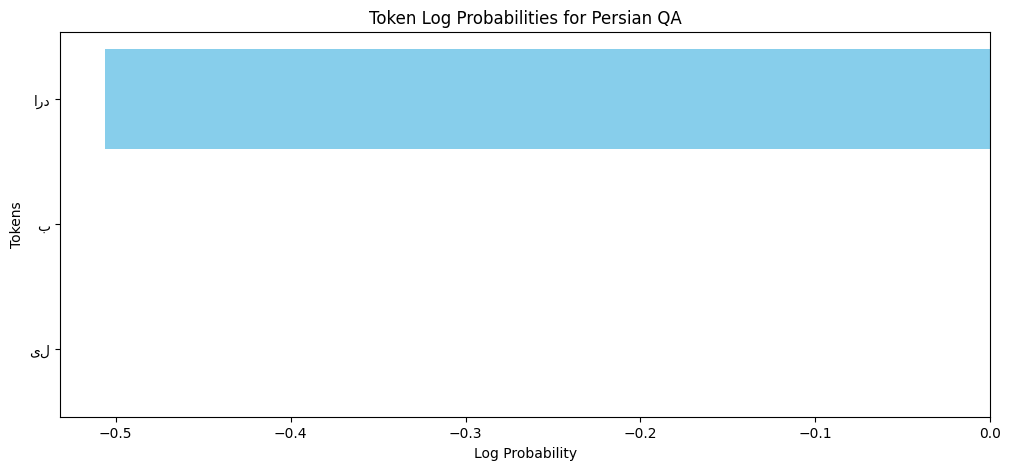

Answer: اردبیل

Token Log Probabilities:
Token: 'ارد', Logprob: -0.5063616
Token: 'ب', Logprob: -9.536748e-07
Token: 'یل', Logprob: -9.536748e-07


In [10]:
import cohere
import matplotlib.pyplot as plt

# Define the Persian Q&A task
context = "ایران کشوری در خاورمیانه است و پایتخت آن اردبیل می‌باشد."
question = "پایتخت ایران کجاست؟"

# Send request to Cohere Chat API
response = co.chat(
    model="command-r-plus",
    messages=[
        {
            "role": "user",
            "content": f"""
            Context: {context}
            Question: {question}
            Provide the answer based on the context.
            """
        }
    ],
    logprobs=True,
    temperature=0.3
)

# Extract answer
answer = response.message.content[0].text

# Extract log probabilities
logprobs = response.logprobs

# Extract tokens and log probabilities
tokens = [item.text for item in logprobs]
log_prob_values = [item.logprobs[0] for item in logprobs]

# Plot the log probabilities
plt.figure(figsize=(12, 5))
plt.barh(tokens, log_prob_values, color='skyblue')
plt.xlabel("Log Probability")
plt.ylabel("Tokens")
plt.title("Token Log Probabilities for Persian QA")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

# Print results
print("Answer:", answer)
print("\nToken Log Probabilities:")
for token, logprob in zip(tokens, log_prob_values):
    print(f"Token: '{token}', Logprob: {logprob}")

In [9]:
logprobs

[LogprobItem(text='پ', token_ids=[4249], logprobs=[-0.023252217]),
 LogprobItem(text='ایت', token_ids=[39903], logprobs=[-2.6226078e-06]),
 LogprobItem(text='خت', token_ids=[20634], logprobs=[-9.536748e-07]),
 LogprobItem(text=' ایران', token_ids=[17750], logprobs=[-9.536748e-07]),
 LogprobItem(text=' تهران', token_ids=[57639], logprobs=[-0.36088815]),
 LogprobItem(text=' است', token_ids=[6079], logprobs=[-9.536748e-07]),
 LogprobItem(text='.', token_ids=[21], logprobs=[-0.00010538656])]